# <center>Créez un outil de visualisation pour un réseau neuronal convolutif</center>

## Contexte du projet

Une startup edtech offre des services de vulgarisation de l'IA.  
Notre équipe (Mélody, Matthis & Toska) sont chargé de répondre au souhait du client :  
**Avoir un outil de démo pour expliquer comment fonctionne un réseau de neurones.**  

​

Notre premier objectif est de créer un modèle de **Deep Learning** pour **classifier des chiffres**. Nous devons développer l'interface utilisateur (avec **Streamlit**) qui permet de dessiner un chiffre (ou choisir aléatoirement un chiffre d'un dataset d'images) et de **détecter** s'il correspond à **un chiffre entre 1 & 9**.  

​

source image : https://www.mdpi.com/2076-3417/9/15/3169  

​

Pour l'interface utilisateur, notre **première version streamlit** doit être capable de **montrer une image aléatoire du dataset test**. Ensuite, grâce à un bouton "predict", notre modèle peut prédire le bon nombre et afficher le résultat dans l'interface. À la fin, l'interface doit nous permettre avec un bouton de valider si le modèle a correctement classé l'image ou non.  

​

Dans un deuxième temps, nous essayerons de faire évoluer notre interface comme un jeu.  
Dans cette deuxième version, l'interface doit nous permettre de dessiner un nombre et le transformer en image. Cette image va ensuite être utilisée par le modèle pour prédire le bon nombre et afficher le résultat. L'idée derrière est de donner 10 opportunités à votre modèle de détecter le chiffre dessiné et donner des stats à la fin par rapport à sa performance de prédiction.  

​

Inspiration d'interface pour faire évoluer notre démo : https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html  

## Librairies

In [11]:
import numpy as np
import pandas as pd
from math import *

#viz
import seaborn as sns
import matplotlib.pyplot as plt


#modeling
import tensorflow as tf
#preprocessing
from keras.preprocessing.image import ImageDataGenerator 
# convert to one-hot-encoding
from keras.utils.np_utils import to_categorical
#neuronal network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
#early stopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend,callbacks,initializers,backend

#plot model
from sklearn.metrics import confusion_matrix
import itertools

## Importation des données

In [12]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

Nous avons donc nos deux datasets. Le test ne servira qu'à la fin.  
Nous allons nous concentrer sur le train.    

Nous allons afficher notre train.  

In [13]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Analyse de la donnée

Il s'agit d'un tableau rempli de données correspondant aux pixels des images.  
Notre target est **label**.  

In [14]:
y = train["label"]
X = train.drop(labels = ["label"],axis = 1)

Après avoir séparé la target du reste du df, nous pouvons procéder à son étude.  

In [15]:
y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

La target est assez équilibrée.  
Nous pouvons mieux nous en rendre compte avec un graphique :  

<AxesSubplot:xlabel='label', ylabel='count'>

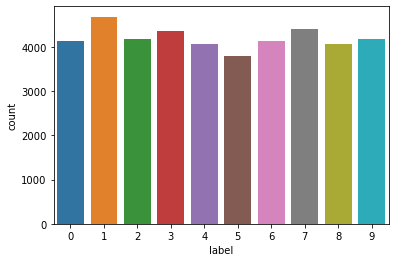

In [16]:
sns.countplot(x= y)

In [17]:
X.shape #taille du df

(42000, 784)

In [18]:
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [19]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [20]:
X.isnull().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

Pas de données manquantes dans le train et le test.  

In [21]:
print(sqrt(784)) #dimension de l'image

28.0


## Presprocessing

On change la dimension pour qu'il puisse lire en 3D.  

In [22]:
# Normalize the data
X_train = X / 255.0
test = test / 255.0
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 784)
test shape:  (28000, 784)


In [23]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [24]:
# Label Encoding 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y_train = to_categorical(y, num_classes = 10)

In [25]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Nous séparons la data pour faire un train et un test sets.  
test size is 10%.  
train size is 90%. 

In [26]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_val.shape)

x_train shape (29400, 28, 28, 1)
x_test shape (12600, 28, 28, 1)
y_train shape (29400, 10)
y_test shape (12600, 10)


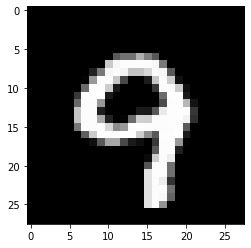

In [27]:
# Some examples
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

## Creat the model

In [39]:
model = Sequential()
#
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999) # Define the optimizer
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 30 # for better result increase the epochs
batch_size= 32

early_stopping =  callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=3, # how many epochs to wait before stopping
    restore_best_weights=True)

# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)


# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              callbacks= early_stopping,
                              steps_per_epoch=X_train.shape[0] // batch_size)

model.summary()

Epoch 1/30
918/918 [==============================] - 48s 52ms/step - loss: 0.4467 - accuracy: 0.8576 - val_loss: 0.0779 - val_accuracy: 0.9764
Epoch 2/30
918/918 [==============================] - 48s 52ms/step - loss: 0.1650 - accuracy: 0.9494 - val_loss: 0.0540 - val_accuracy: 0.9838
Epoch 3/30
918/918 [==============================] - 46s 50ms/step - loss: 0.1313 - accuracy: 0.9600 - val_loss: 0.0488 - val_accuracy: 0.9850
Epoch 4/30
918/918 [==============================] - 44s 48ms/step - loss: 0.1149 - accuracy: 0.9653 - val_loss: 0.0364 - val_accuracy: 0.9875
Epoch 5/30
918/918 [==============================] - 44s 48ms/step - loss: 0.0949 - accuracy: 0.9706 - val_loss: 0.0393 - val_accuracy: 0.9879
Epoch 6/30
918/918 [==============================] - 44s 48ms/step - loss: 0.0914 - accuracy: 0.9729 - val_loss: 0.0402 - val_accuracy: 0.9873
Epoch 7/30
918/918 [==============================] - 46s 50ms/step - loss: 0.0864 - accuracy: 0.9747 - val_loss: 0.0374 - val_accuracy:

In [44]:
# evaluate the model
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 99.09%


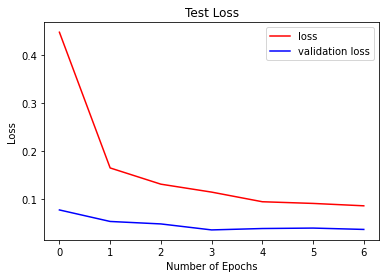

In [40]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['loss'], color ="r", label ="loss")
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

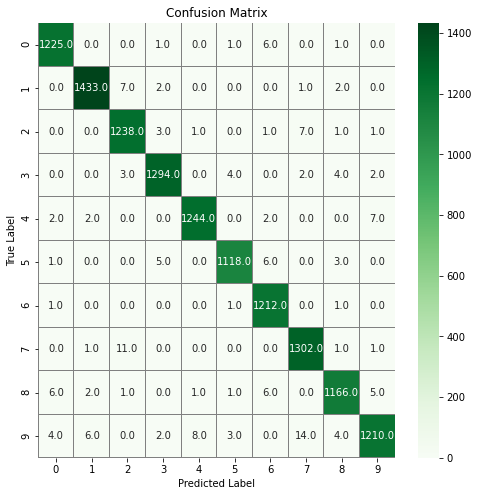

In [41]:
# confusion matrix

# Predict the values from the validation dataset
y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [50]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1234
           1       0.99      0.99      0.99      1445
           2       0.98      0.99      0.99      1252
           3       0.99      0.99      0.99      1309
           4       0.99      0.99      0.99      1257
           5       0.99      0.99      0.99      1133
           6       0.98      1.00      0.99      1215
           7       0.98      0.99      0.99      1316
           8       0.99      0.98      0.98      1188
           9       0.99      0.97      0.98      1251

    accuracy                           0.99     12600
   macro avg       0.99      0.99      0.99     12600
weighted avg       0.99      0.99      0.99     12600



<ipython-input-42-c9b7b0397c1b>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Xs = X - Xmean[None,:]


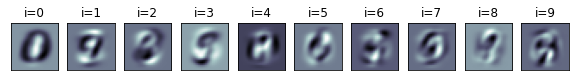

In [42]:
def plt_face(X_train):
    h = 28
    w = 28
    plt.imshow(X_train.reshape((h, w)), cmap='bone')
    plt.xticks([])
    plt.yticks([])


# plt_face(X[0])
Xmean = np.mean(X,0)
Xs = X - Xmean[None,:]
U,S,Vtr = np.linalg.svd(Xs, full_matrices=False)


nplt = 10
plt.figure(figsize=(10, 20))
for i in range(nplt):
    plt.subplot(1,nplt,i+1)
    Vi = Vtr[i,:]
    plt_face(Vtr[i,:])
    plt.title('i={0:d}'.format(i))

## Keras model (Save)

In [51]:
from tensorflow.keras.models import save_model, load_model

In [61]:
# ##### SAVE MODEL JUST ONE TIME #####
save_model(model,'model.h5')